In [63]:
import pprint
import copy
import arviz as az
import corner
import emcee
import matplotlib.pyplot as plt
import numpy as np
from george.gp import LinAlgError
import yaml
from matplotlib import cm
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from astropy.timeseries import LombScargle
import dynesty
from dynesty import plotting as dyplot
import radvel

## Target selection

In [64]:
print('Welcome to the joint RV analysis tool!')
print('Which star would you like to analyze?')

star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise

Welcome to the joint RV analysis tool!
Which star would you like to analyze?
Loading input file and data...


For target with no Dtemp data

In [65]:
no_Dtemp = True

Do you want to run the activity indicator analysis and/or the search for planets

In [66]:
run_activity = True
run_planet_search = True

## Loading data

In [67]:
data = rv.DataLoader(yaml_file, no_Dtemp=no_Dtemp)

i_shared = data.activity_priors['shared_params']
gp_labels = rv.generate_param_names(['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot'],
                                    i_shared, data.instruments)
print('Done.')

Done.


Substracting the mean

In [68]:
for instrument in data.instruments: 
    data.y_rv[instrument] -= np.mean(data.y_rv[instrument])

Matplotlib preferences

In [69]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

## Periodogram 

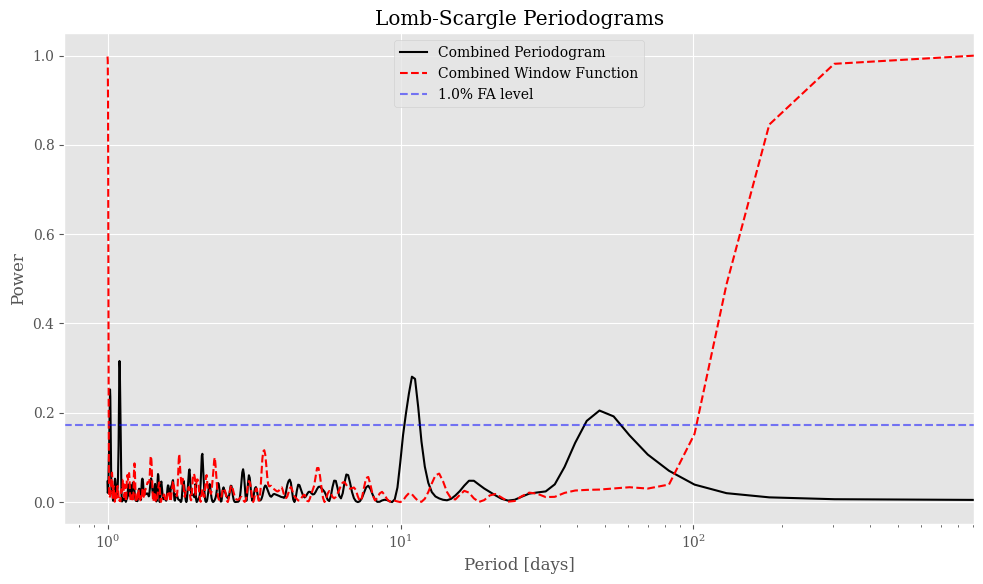

In [70]:
rv.plot_lombscargle_periodograms(data.t_rv, data.y_rv, data.yerr_rv, combined = True)

# Activity indicators

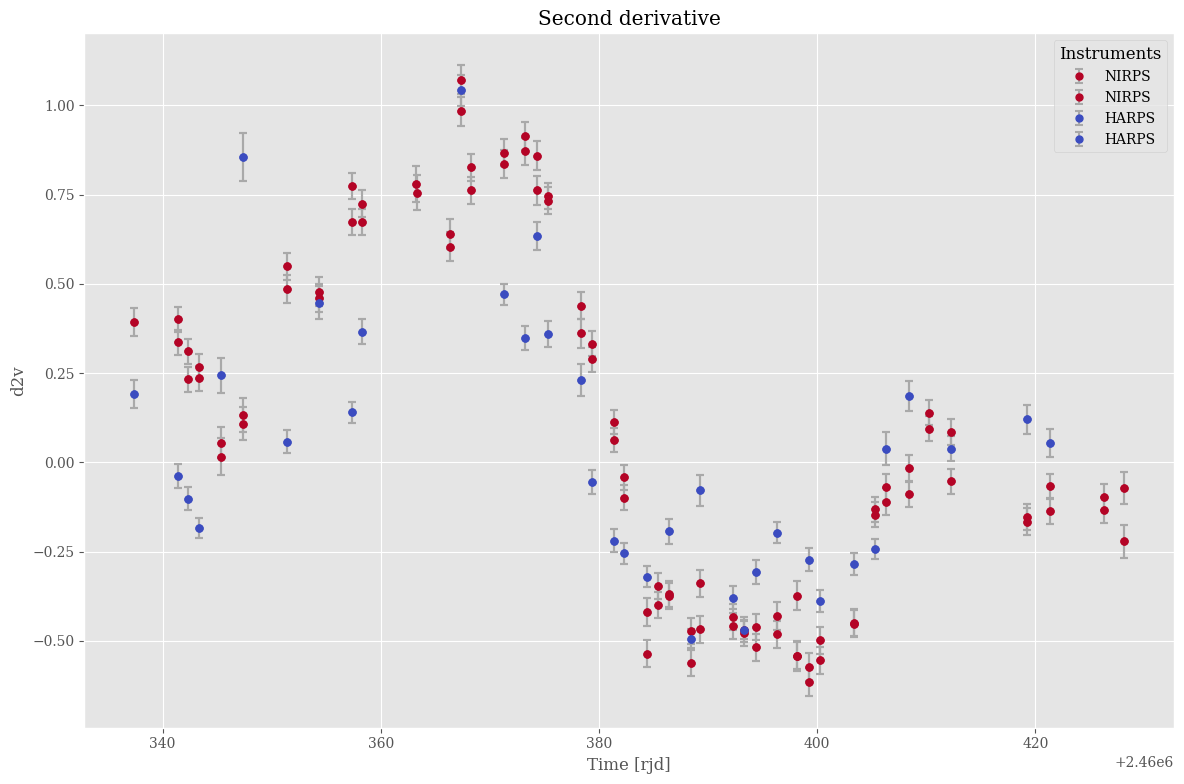

In [71]:
# Plot the chosen activity indicator
nfigs = 2 - no_Dtemp
fig, axes = plt.subplots(nfigs, 1, figsize=(12, 8), sharex=True)

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    axes.errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    if not no_Dtemp:
        axes[0].errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes[1].errorbar(data.t_rv[instrument], data.Dtemp[instrument], yerr=data.sDtemp[instrument], fmt='o',
                        label=instrument, color=colors[idx], 
                    ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)

        axes[1].set_xlabel('Time [rjd]')
        axes[0].set_ylabel('d2v')
        axes[0].legend(title='Instruments')
        axes[0].set_title('Second derivative')

        axes[1].set_title('Differential temperature')
        axes[1].legend(title='Instruments')
        axes[1].set_ylabel('Dtemp')
    else: 
        axes.errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
        axes.set_xlabel('Time [rjd]')
        axes.set_ylabel('d2v')
        axes.legend(title='Instruments')
        axes.set_title('Second derivative')
plt.show()

Choose the activity indicator

In [72]:
if data.activity_priors['chosen_activity'] == 'd2v': 
    act, sact = data.d2v, data.sd2v

if data.activity_priors['chosen_activity'] == 'Dtemp': 
    act, sact = data.Dtemp, data.sDtemp
    
print(f'You chose to use the {data.activity_priors["chosen_activity"]} activity indicator.')

You chose to use the d2v activity indicator.


## Creating the GP object

GP params order: 

0. `mu` (offset)
1. `log_wn` (jitter noise)
2. `log_amp` (amplitude)
3. `log_lambda` (Coherence length)
4. `gamma` (Number of sub-structures)
5. `log_Prot` (Rotation period)

First Guess

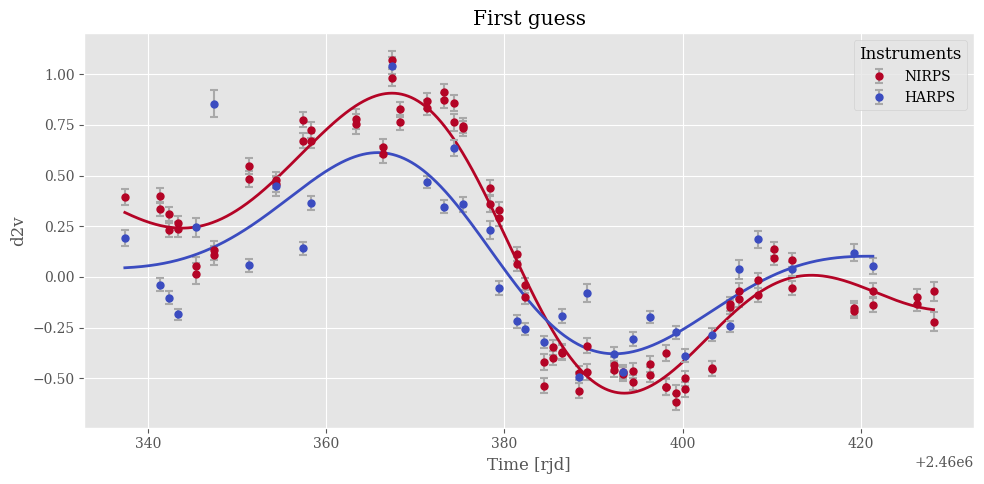

In [73]:
act_gp = {} # Dictionary to store the GP for each instrument
p0 = {} # Dictionary to store the initial guess for the hyperparameters

for instrument in data.instruments: 
    
    p0[instrument] = rv.juliet_to_george([np.mean(act[instrument]), 0.1, np.std(act[instrument]),
           data.activity_priors['GP_length']['guess'], data.activity_priors['GP_gamma']['guess'], data.activity_priors['GP_Prot']['guess']]) # Initial guess for the hyperparameters
    
    act_gp[instrument] = rv.QP_GP_Model(p0[instrument], data.t_rv[instrument], act[instrument], sact[instrument])
# Plot the first guess
# Plot the chosen activity indicator
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                    
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], act[instrument], yerr=sact[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], act_gp[instrument].predict(data.t_mod[instrument]), color=colors[idx], lw=2)

ax.set_xlabel('Time [rjd]')
ax.set_ylabel(data.activity_priors['chosen_activity'])
ax.legend(title='Instruments')
ax.set_title('First guess')
plt.show()

## Combining the shared parameters and computing initial guess

In [74]:
p0_separated = []

for instrument in data.instruments: 
    p0_separated += list(p0[instrument])

p0_vect = rv.params_vector(p0_separated, data.instruments, i_shared, num_planets = data.nplanets, gp_only=True)

comb_p0 = p0_vect.combine()

## Running `emcee`

In [75]:
# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 32, len(comb_p0)
num_warmup = 600
num_post_samples = 2500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    rv.act_log_post,
    args=(act_gp, act, data, i_shared),
    # moves=[emcee.moves.StretchMove()]
    moves=[emcee.moves.DEMove()],
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)])

$\color{red}{\textrm{RUNNING CELL}}$

In [76]:
if run_activity == True:
    print('Running MCMC fit for the activity indicator...')
    sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True, store=True)
    act_post_samples = sampler.get_chain(discard=num_warmup)
    np.save(f'stars/{star}/joint_fit/act_post_samples.npy', act_post_samples)
    print('Done')

Running MCMC fit for the activity indicator...


100%|██████████| 3100/3100 [02:47<00:00, 18.55it/s]

Done


Load the already ran target

In [77]:
act_post_samples = np.load(f'stars/{star}/joint_fit/act_post_samples.npy', allow_pickle=True)

Traceplot

Plotting traceplot...
Done.


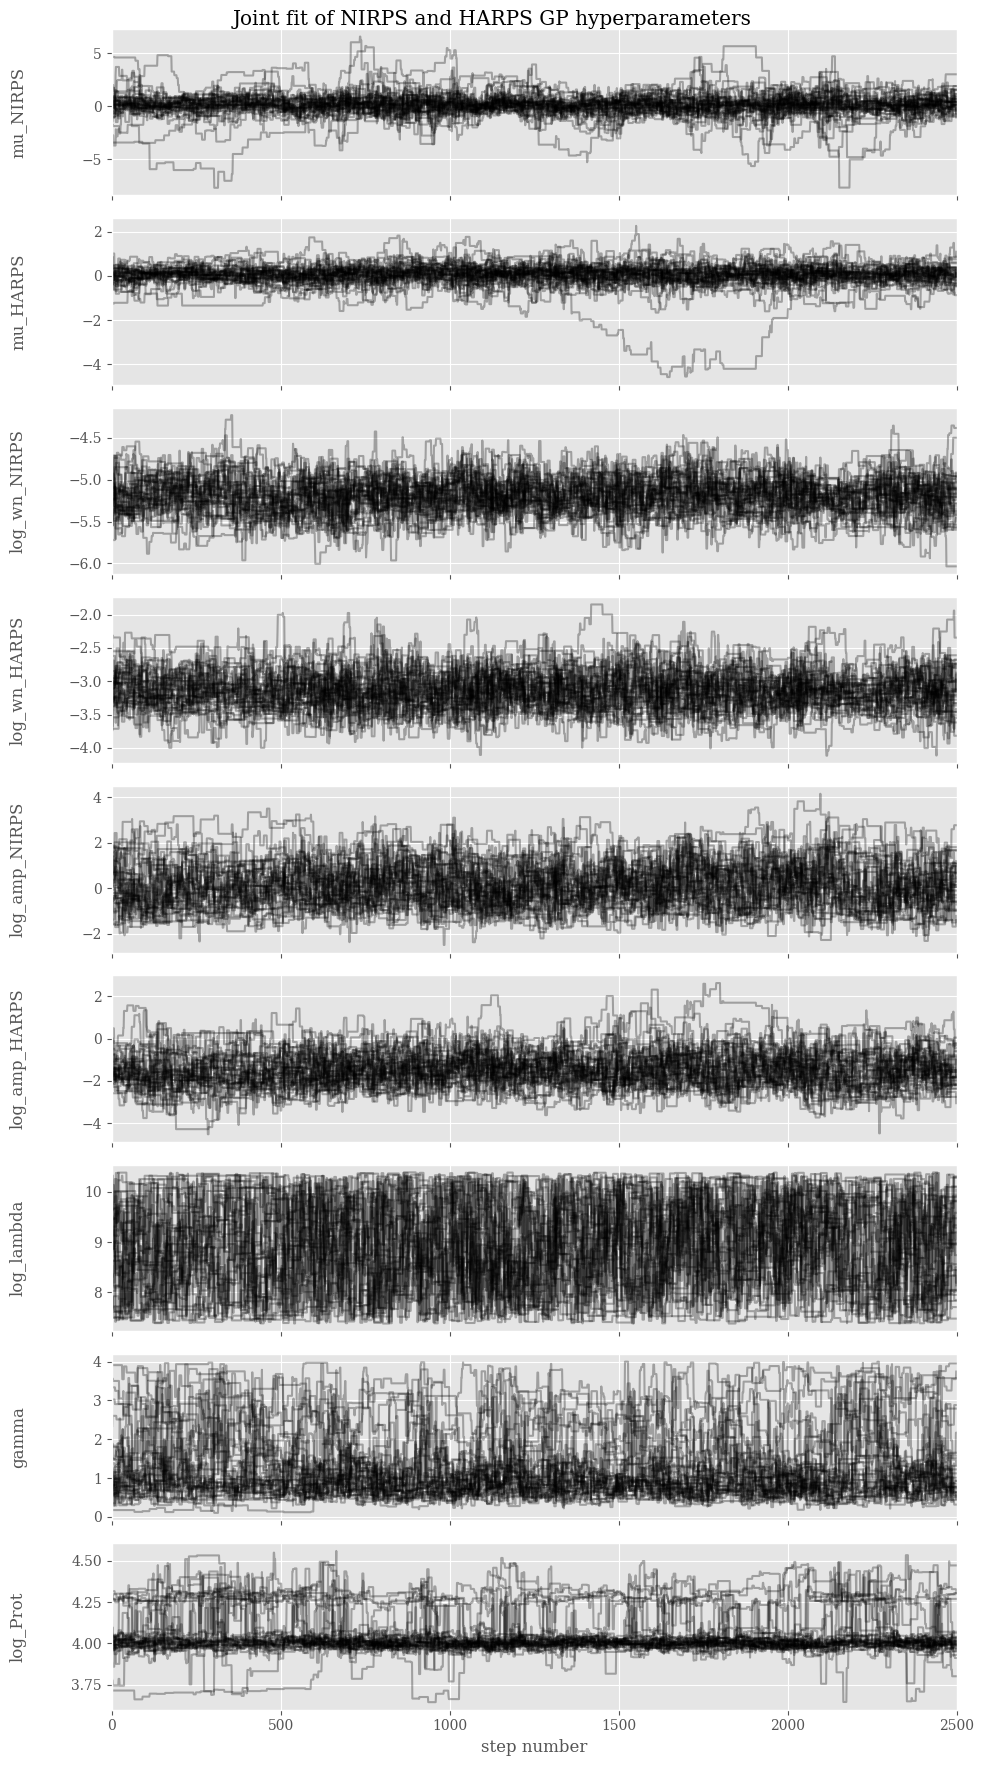

In [78]:
print('Plotting traceplot...')
fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)


for i in range(ndim):
    ax = axes[i]
    ax.plot(act_post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(act_post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(gp_labels[i])
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS GP hyperparameters')
plt.savefig(f"stars/{star}/joint_fit/act_GP_traceplot.png")
print('Done.')

Corner plot

Creating corner plot for the activity indicator


Done.


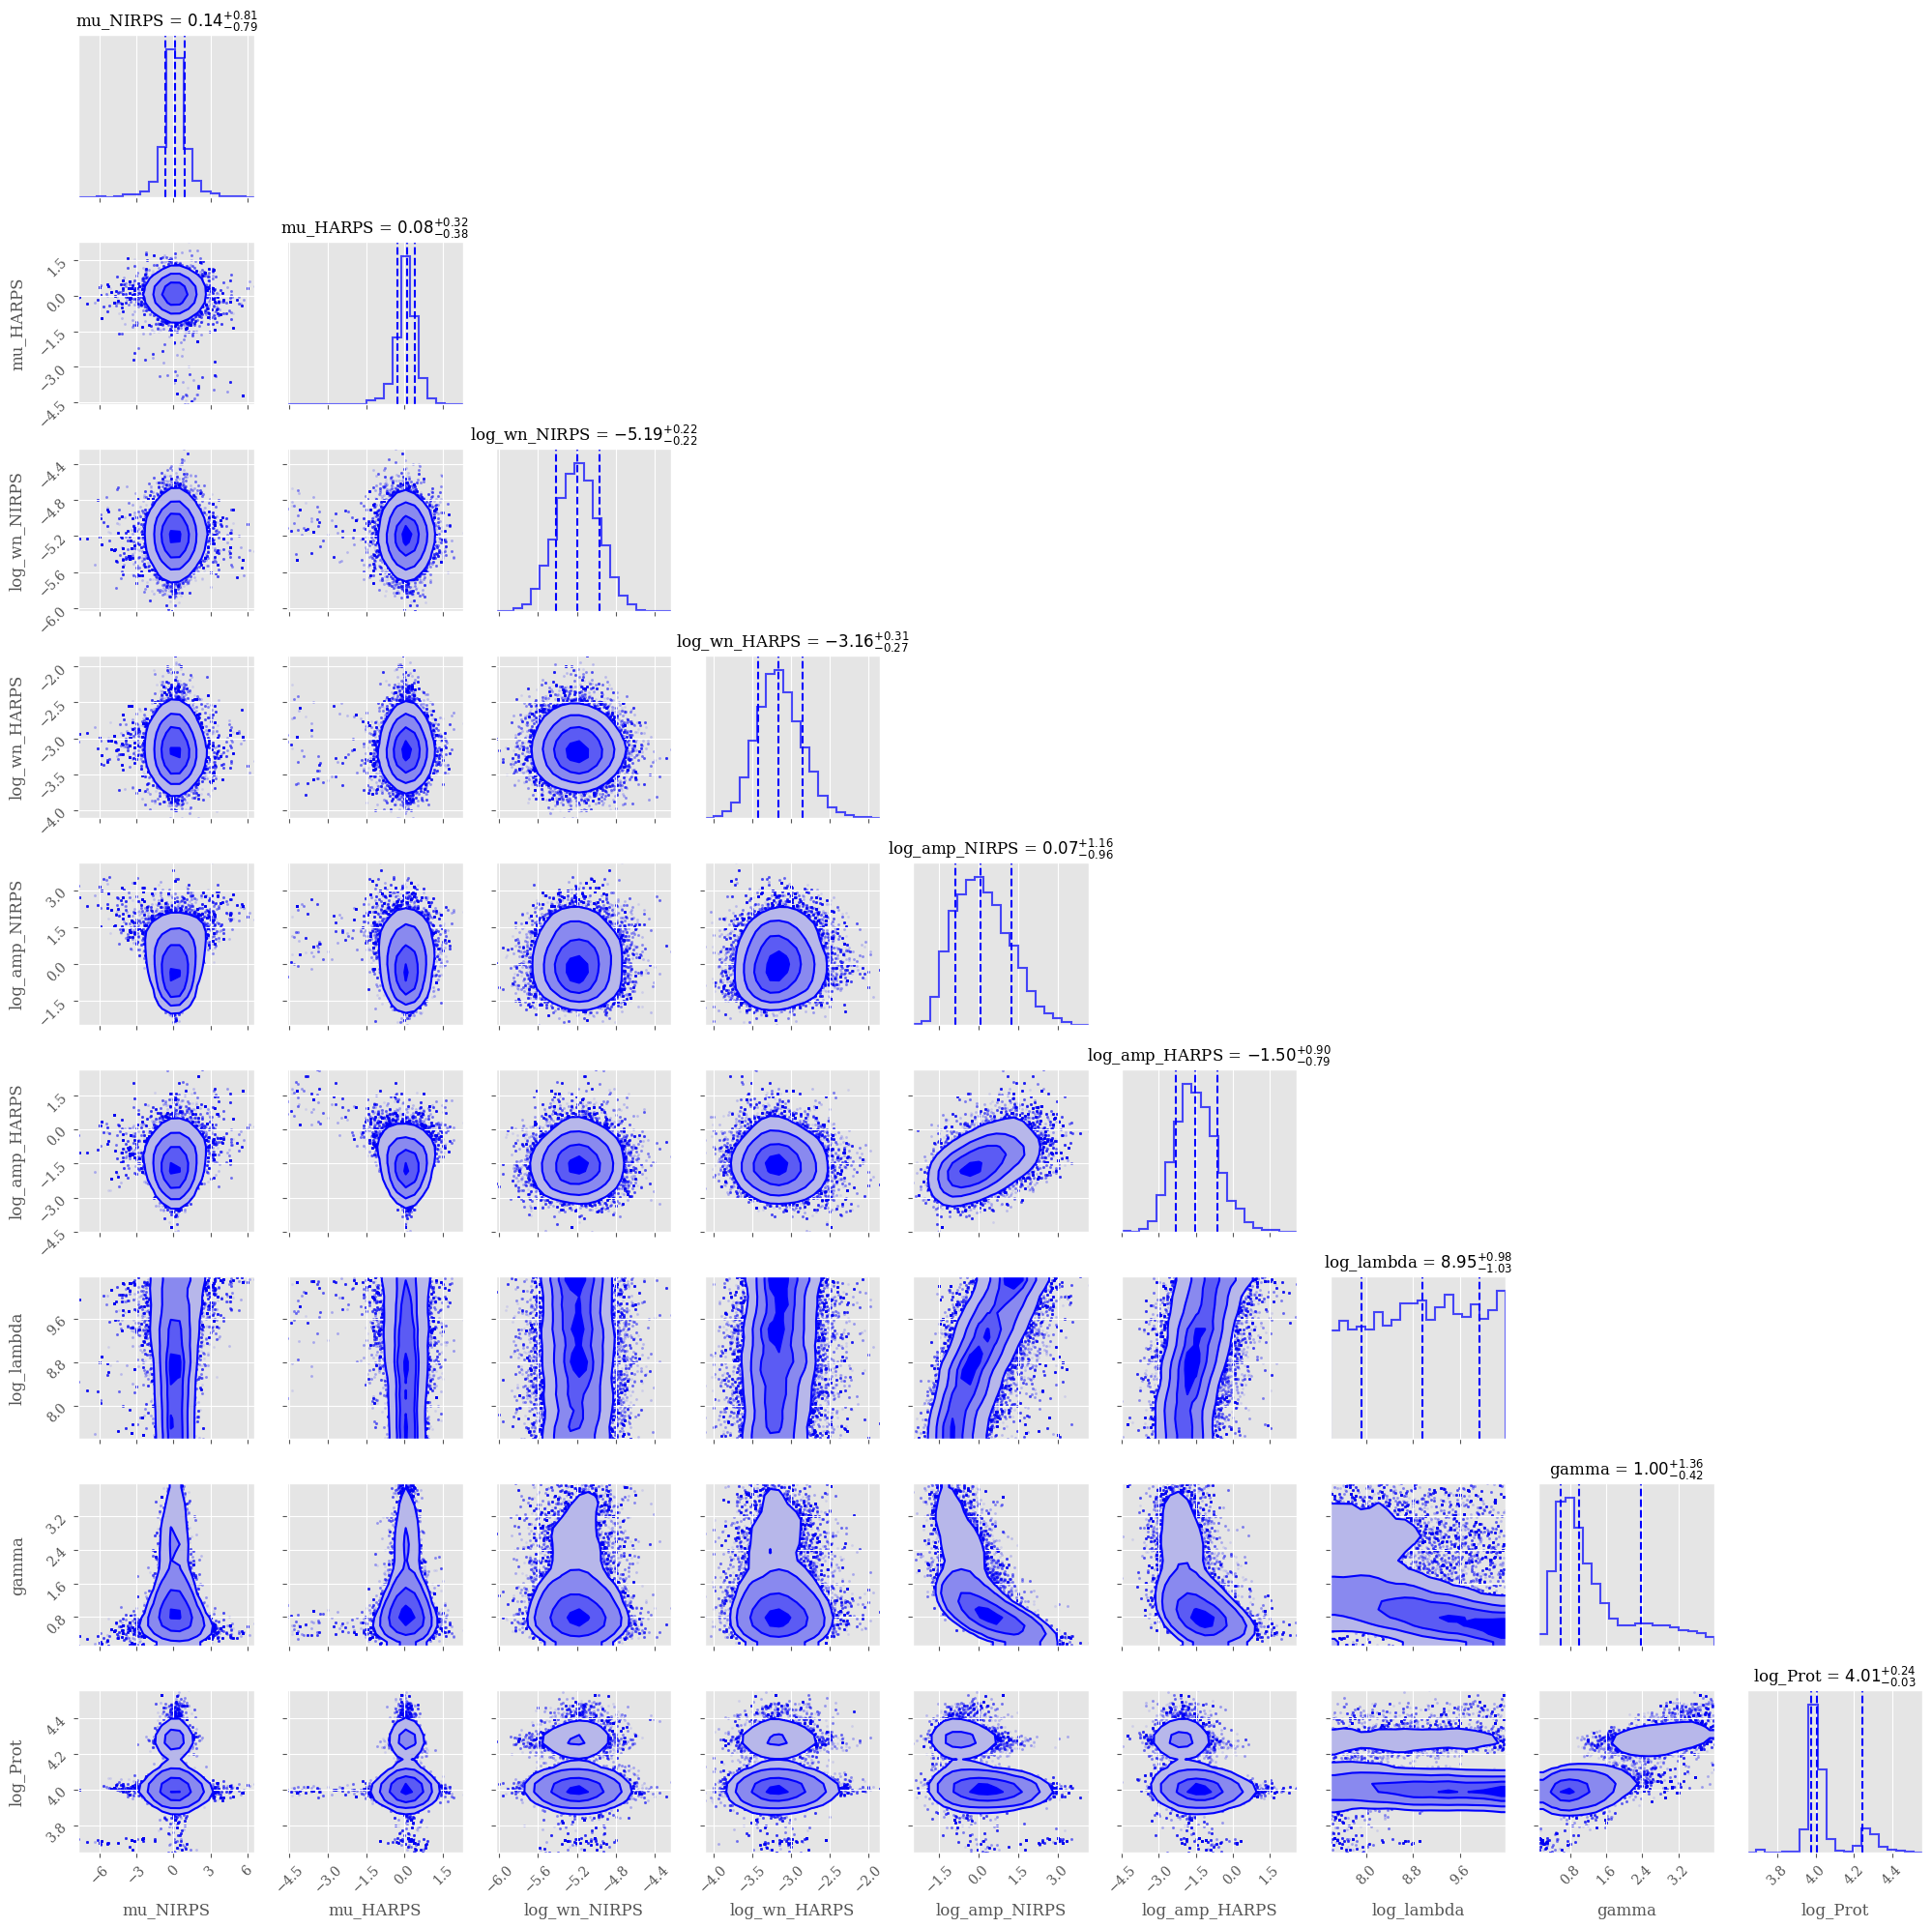

In [79]:
print('Creating corner plot for the activity indicator')
#truths = [None, None, None, None, None, None, None, None, np.log(data.data['star']['period'])]

corner.corner(act_post_samples.reshape(-1, ndim), quantiles=[0.16, 0.5, 0.84],
              show_titles=True,
              title_kwargs={"fontsize": 12},
              color="blue",  # Set a color scheme (optional)
              hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
              fill_contours=True,  # Show contours for data density
              fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
              smooth=True,  # Improve smoothness of contours
              fontsize=10,  # Set font size for labels and tick marks
              #truths=truths,
              #truth_color = 'orange',
              labels=gp_labels
)
plt.tight_layout()
plt.savefig(f"stars/{star}/joint_fit/act_GP_cornerplot.png")
print('Done.')

In [80]:
median_likelihood_params = np.median(act_post_samples, axis=(0,1))

print(f"Median likelihood parameters")
print('--------------------------')
# Show the median likelihood parameters
for i, label in enumerate(gp_labels):
    print(f'{label}: {median_likelihood_params[i]:.3f}')


Median likelihood parameters
--------------------------
mu_NIRPS: 0.140
mu_HARPS: 0.081
log_wn_NIRPS: -5.194
log_wn_HARPS: -3.156
log_amp_NIRPS: 0.067
log_amp_HARPS: -1.504
log_lambda: 8.953
gamma: 1.004
log_Prot: 4.009


Creating posterior samples

In [81]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 20
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in act_gp.keys()}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    _, act_post_samples_dict = rv.separate_gp_params(act_post_samples[n, w], i_shared, act_gp.keys())

    try:
        for instrument, gp_model in act_gp.items():
            gp_params = act_post_samples_dict[instrument]
            gp_model.gp.set_parameter_vector(gp_params)
            model_post_samples[instrument].append(gp_model.gp.sample_conditional(act[instrument], data.t_mod[instrument]))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done.')

Creating posterior samples...


Done.


Plotting the best-fit results
Done.


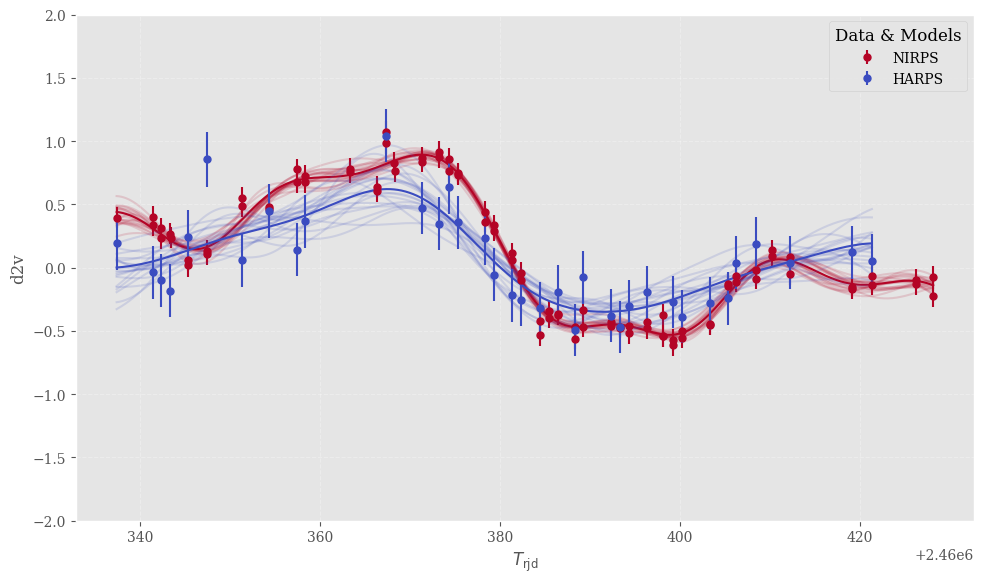

In [82]:
print('Plotting the best-fit results')

# Separate the parameters for each instrument
_, act_med_params = rv.separate_gp_params(median_likelihood_params, i_shared, act_gp.keys())

# Initialize dictionaries to store predictions and standard deviations
mu_med = {}
std_med = {}

# Predict for each instrument
for instrument, gp_model in act_gp.items():
    # Median likelihood parameters
    gp_model.gp.set_parameter_vector(act_med_params[instrument])
    mu_med[instrument], var_med = gp_model.gp.predict(act[instrument], data.t_mod[instrument], return_var=True)

# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
colors = cm.coolwarm(np.linspace(1, 0, len(act_gp)))  # Use coolwarm colormap for consistency

for idx, (instrument, color) in enumerate(zip(act_gp.keys(), colors)):
    # Plot data with error bars
    axes.errorbar(data.t_rv[instrument], act[instrument], yerr=np.sqrt(sact[instrument]**2 + np.exp(act_med_params[instrument][1])), 
                  fmt="o", ms=5, label=instrument, color=color)
    
    # Plot samples from posterior
    axes.plot(data.t_mod[instrument], model_post_samples[instrument].T, color=color, alpha=0.15)
    
    # Plot median likelihood
    axes.plot(data.t_mod[instrument], mu_med[instrument], color=color, linewidth=1.5)

# Axes and labels
axes.set_ylabel(f"{data.activity_priors['chosen_activity']}")
axes.set_xlabel(r"$T_{\rm rjd}$")  # Use Latex for unit

# Conditionally setting y-limits based on activity indicator
if data.activity_priors['chosen_activity'] == 'Dtemp': 
    plt.ylim(bottom=-50, top=50)
if data.activity_priors['chosen_activity'] == 'd2v': 
    plt.ylim(bottom=-2, top=2)

axes.grid(linestyle='--', alpha=0.3)
plt.legend(title="Data & Models", loc='upper right')  # Adjust legend position
plt.tight_layout()  # Adjust spacing

# Saving figure
star_name = data.data['star']['name']
file_path = f"stars/{star_name}/joint_fit/{data.activity_priors['chosen_activity']}_GP_MC_fit.png"
plt.savefig(file_path, dpi=300)  # Ensure high resolution

print('Done.')


# Planets + GP analysis

## Exemple of the parameter vector to enter in the Planet_GP_Model object: 

p = [planets parameters, GP parameters]

**p = [per1, tc1, k1, ... (other planets), mu_NIRPS, noise_NIRPS, amp_NIRPS, coherence_length_NIRPS, gamma_NIRPS, Prot_NIRPS, ... (other instruments) ]**

### Loading the initial guess parameter vector

In [83]:
import importlib
importlib.reload(rv)

<module 'rv_analysis_tools' from '/home/plamontagne/nirps/rv_analysis_tools.py'>

In [104]:
# Extract the number of planets from the RV priors
num_planets = data.nplanets

print(f'Creating initial guess for the RV parameters for {num_planets} planets and activity...')

# Initialize lists to hold planet parameters and labels
p0 = []
planet_labels = []
priors = {}  # Dictionary to store the priors
prior_params_names = ['mu', 'noise', 'GP_sigma', 'GP_length', 'GP_gamma', 'GP_Prot']
act_samples_dict = rv.separate_gp_params_samples(act_post_samples, i_shared, data.instruments) # Contains the samples for the parameters of each instrument

# Loop over the number of planets to construct the parameter and label lists
for i in range(1, num_planets + 1):

    p0.extend([
        data.RV_priors[f'per{i}']['guess'],
        data.RV_priors[f'tc{i}']['guess'],
        data.RV_priors[f'k{i}']['guess']
    ])
    planet_labels.extend([f'per{i}', f'tc{i}', f'k{i}'])

# Loop over the instruments to construct the GP parameter list
for inst in data.instruments: 
    priors[inst] = copy.deepcopy(data.RV_priors)
    
for instrument in data.instruments: 
    if data.use_indicator:
        # Create the initial vector from the activity indicator
        p0.extend(
            [np.mean(data.y_rv[instrument]), np.log(0.1**2), np.log(np.std(data.y_rv[instrument])**2),
            act_med_params[instrument][3], act_med_params[instrument][4], act_med_params[instrument][5]])
    
        # Add priors for GP parameters
        for idx, param_name in enumerate(prior_params_names):
            if param_name == 'GP_length':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(np.sqrt(np.exp(act_samples_dict[instrument][idx]))),
                    'std': np.std(np.sqrt(np.exp(act_samples_dict[instrument][idx])))
                }
            elif param_name == 'GP_gamma':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(act_samples_dict[instrument][idx]),
                    'std': np.std(act_samples_dict[instrument][idx])
                }
            elif param_name == 'GP_Prot':
                priors[instrument][param_name] = {
                    'distribution': 'Normal',
                    'mean': np.median(np.exp(act_samples_dict[instrument][idx])),
                    'std': np.std(np.exp(act_samples_dict[instrument][idx])), 
                    'min': np.median(np.exp(act_samples_dict[instrument][idx])) - 10,
                    'max': np.median(np.exp(act_samples_dict[instrument][idx])) + 10
                }
            else: 
                continue

    else:
        p0.extend(rv.juliet_to_george([
            np.mean(data.y_rv[instrument]), 0.1, np.std(data.y_rv[instrument]),
            data.RV_priors['GP_length']['guess'], data.RV_priors['GP_gamma']['guess'], data.RV_priors['GP_Prot']['guess']
        ]))
        
        priors[instrument] = data.RV_priors
# Create parameter vector
p0_vect = rv.params_vector(p0, data.instruments, i_shared, num_planets=num_planets)
comb_p0 = p0_vect.combine()
param_labels = np.concatenate([planet_labels, gp_labels]) 

print('Initial guess parameter vector:')
print('--------------------------')
for i, label in enumerate(param_labels):
    print(f'{label}: {comb_p0[i]:.3f}')

print('Priors:')
print('--------------------------')
print(priors) 

Creating initial guess for the RV parameters for 1 planets and activity...
Initial guess parameter vector:
--------------------------
per1: 11.187
tc1: 2457897.900
k1: 1.300
mu_NIRPS: 0.000
mu_HARPS: -0.000
log_wn_NIRPS: -4.605
log_wn_HARPS: -4.605
log_amp_NIRPS: 0.982
log_amp_HARPS: 2.036
log_lambda: 8.953
gamma: 1.004
log_Prot: 4.009
Priors:
--------------------------
{'NIRPS': {'mu': {'guess': 0.0, 'distribution': 'Normal', 'mean': 0.0, 'std': 5.0, 'min': -10.0, 'max': 10.0}, 'noise': {'guess': 1.0, 'distribution': 'Uniform', 'mean': 1.0, 'std': 1.0, 'min': 0.001, 'max': 100.0}, 'GP_Prot': {'distribution': 'Normal', 'mean': 55.07108735149527, 'std': 8.159382941130827, 'min': 45.07108735149527, 'max': 65.07108735149527}, 'GP_sigma': {'guess': 3.0, 'distribution': 'Uniform', 'mean': 1.0, 'std': 1.0, 'min': 0.1, 'max': 100.0}, 'GP_length': {'distribution': 'Normal', 'mean': 87.93595085490561, 'std': 39.79857788258609}, 'GP_gamma': {'distribution': 'Normal', 'mean': 1.0041554281099825, 

## Creating planet + GP model

In [105]:
# Create the Planet+GP model
model = rv.Planet_GP_Model(p0_vect, data.t_rv, data.y_rv, data.yerr_rv, num_planets = num_planets)

Look at first guess

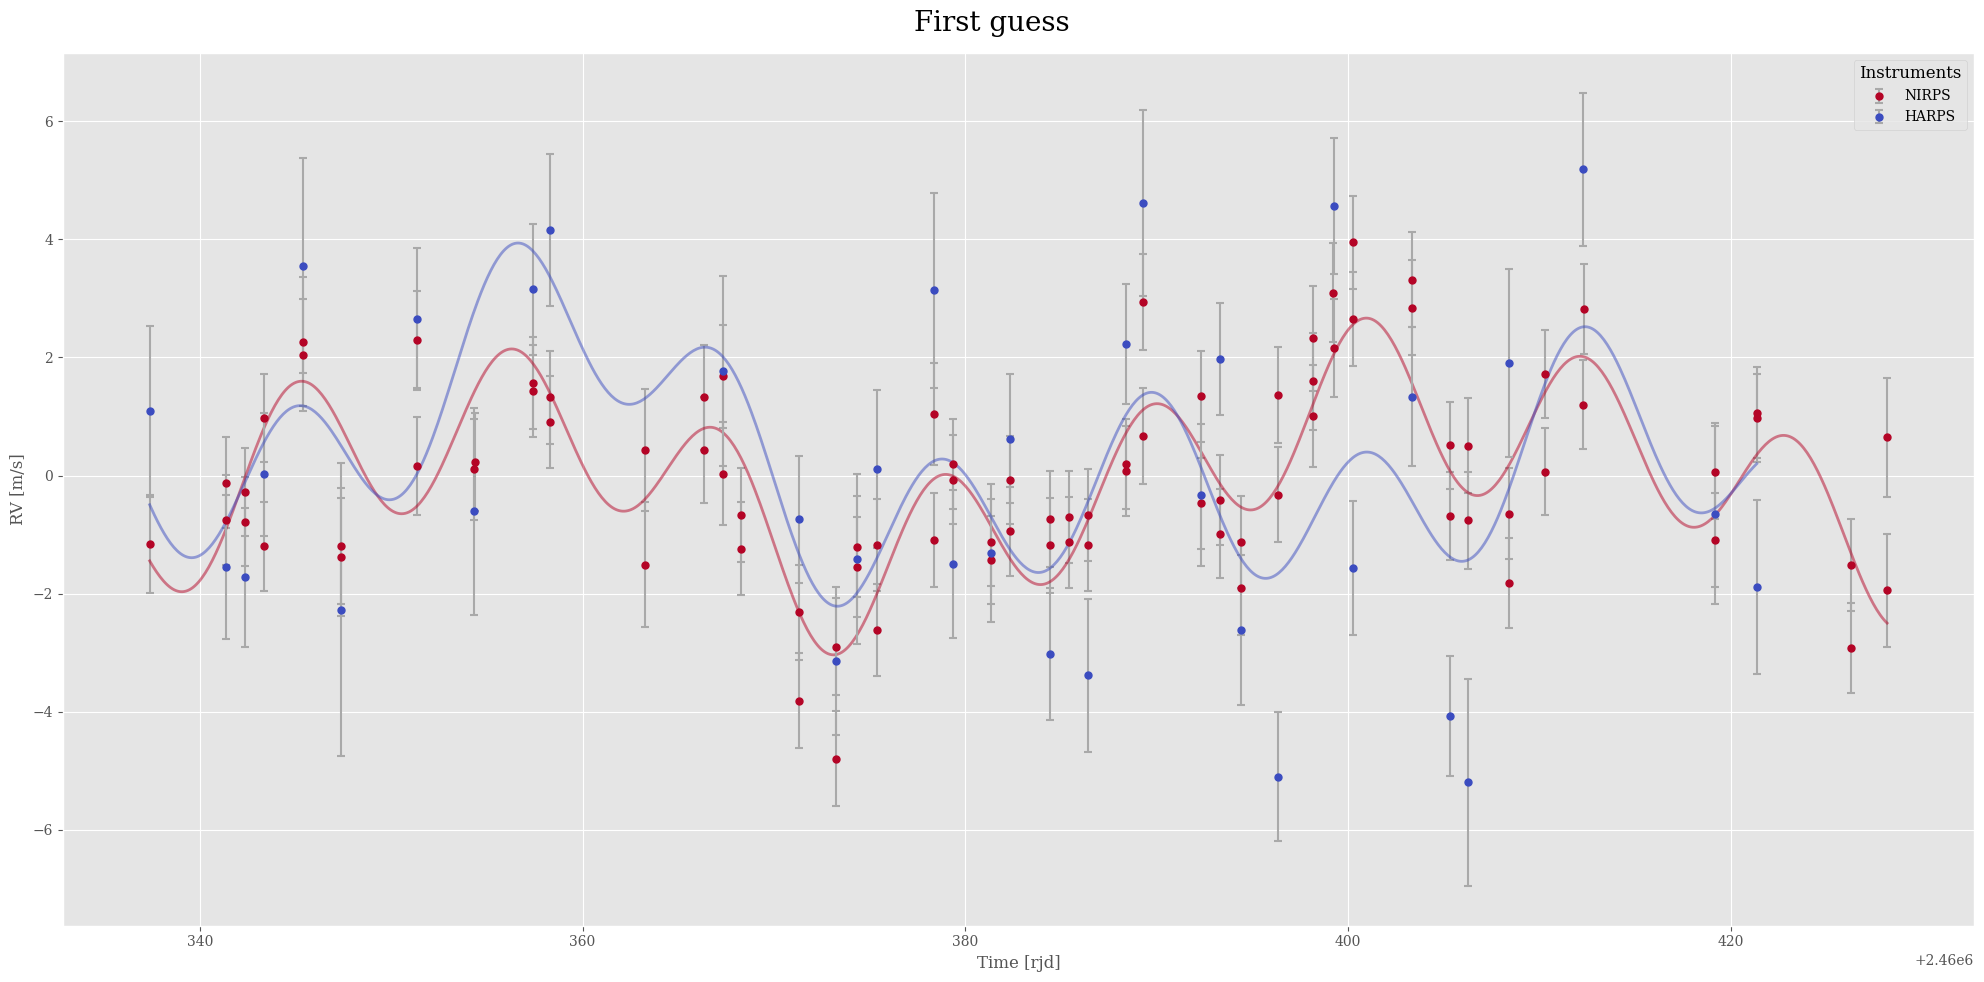

In [106]:
# Plot the RV data and the first guess
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

model.update_params(p0_vect)
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=data.yerr_rv[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod)[instrument], color=colors[idx], lw=2, alpha=0.5)
    
    ax.set_xlabel('Time [rjd]')
    ax.set_ylabel('RV [m/s]')
    
    ax.legend(title='Instruments')
plt.suptitle('First guess', fontsize=20)
plt.show()
    

## Run `emcee`

### Creating a combined parameter vector to use in the MCMC run
This is necessary because we want the shared GP parameters to be updated for all instruments at once.

In [107]:
comb_p0 = p0_vect.combine()

# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 3*len(comb_p0), len(comb_p0)
num_warmup = 1000
num_post_samples = 5000
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    rv.emcee_log_post,
    args=(model, data, priors, i_shared, num_planets),
    moves=[emcee.moves.DEMove()]
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + np.random.randn(ndim) * 1e-4 for i in range(nwalkers)])


In [108]:
if run_planet_search == True:
    print('Running MCMC for the combined model...')
    sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True)
    post_samples = sampler.get_chain(discard=num_warmup)
    np.save(f'stars/{star}/joint_fit/full_post_samples.npy', post_samples)
    print('Done.')

Running MCMC for the combined model...


100%|██████████| 6000/6000 [10:28<00:00,  9.55it/s]

Done.


Loading the already ran target

In [109]:
post_samples = np.load(f"stars/{star}/joint_fit/full_post_samples.npy")

Plotting traceplot...
Done.


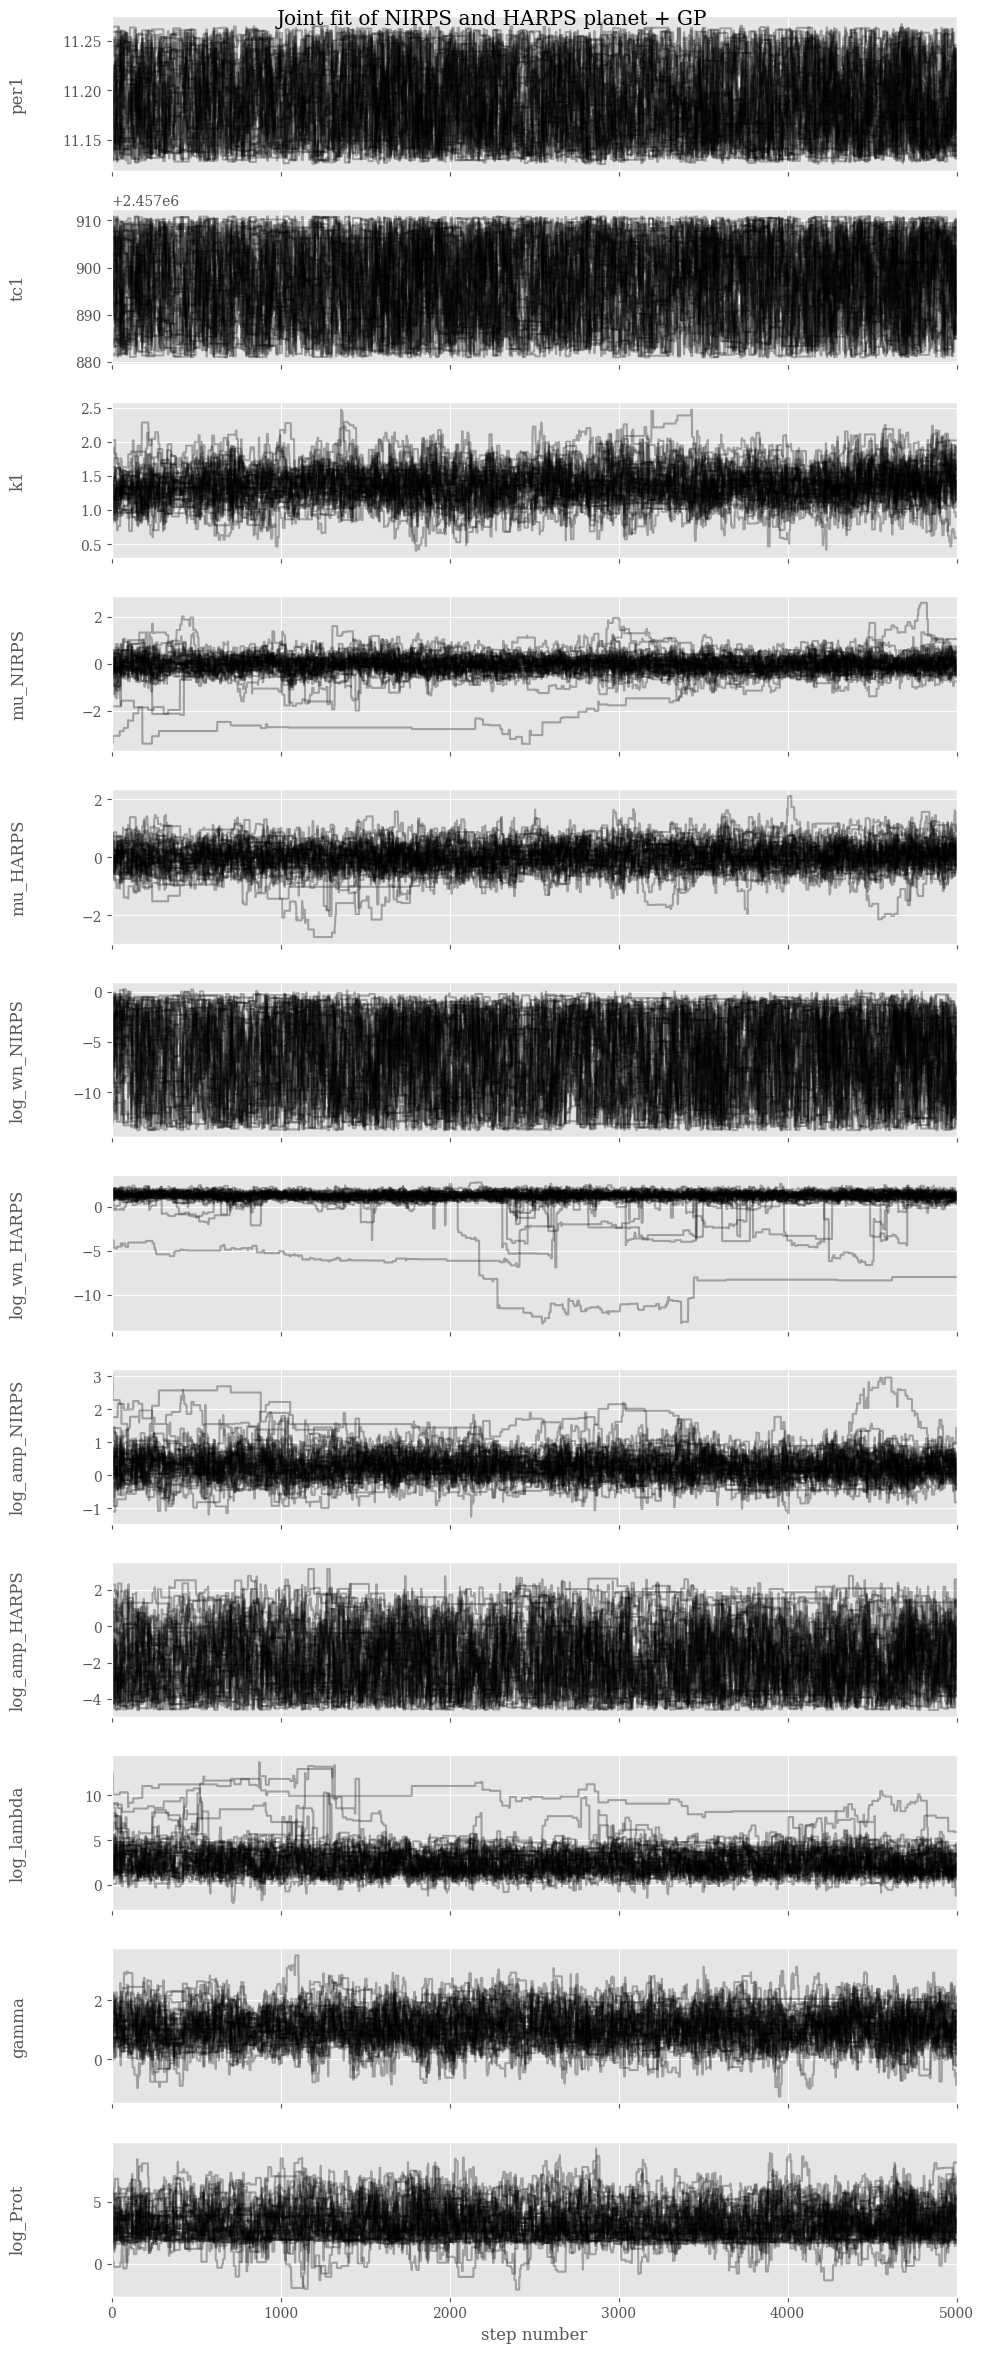

In [110]:
print('Plotting traceplot...')

fig, axes = plt.subplots(ndim, figsize=(10, ndim*2), sharex=True)

# Save the posterior samples
np.save(f'stars/{star}/joint_fit/full_post_samples.npy', post_samples)

for i in range(ndim):
    ax = axes[i]
    ax.plot(post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(param_labels[i])
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS planet + GP')
plt.savefig(f"stars/{star}/joint_fit/planet+GP_traceplot.png")

print('Done.')

In [111]:
med_params = np.median(post_samples, axis=(0,1))

print('Median likelihood parameters')
print('--------------------------')
# Show the median likelihood parameters
for i, label in enumerate(param_labels):
    print(f'{label}: {med_params[i]:.3f}')


Median likelihood parameters
--------------------------
per1: 11.187
tc1: 2457897.611
k1: 1.358
mu_NIRPS: -0.030
mu_HARPS: 0.008
log_wn_NIRPS: -5.861
log_wn_HARPS: 1.279
log_amp_NIRPS: 0.264
log_amp_HARPS: -1.824
log_lambda: 2.765
gamma: 1.080
log_Prot: 3.019


In [112]:
print('Plotting corner plot...')

# Make a corner plot
fig = corner.corner(
    post_samples.reshape(-1, ndim),
    labels=param_labels,
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    color="blue",  # Set a color scheme (optional)
    hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
    fill_contours=True,  # Show contours for data density
    fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
    smooth=True,  # Improve smoothness of contours
    fontsize=10,  # Set font size for labels and tick marks
    truth_color = 'orange',
)

plt.tight_layout()
plt.savefig(f"stars/{star}/joint_fit/planet+GP_cornerplot.png")

print('Done.')

Plotting corner plot...


In [ ]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in data.instruments}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    planet_sample = post_samples[n, w, :3*num_planets]
    gp_samples, gp_samples_dict = rv.separate_gp_params(post_samples[n, w, 3*num_planets:], i_shared, data.instruments)
    try:
        params = np.concatenate([planet_sample, gp_samples])
        model.update_params(params)
        
        for instrument in data.instruments:
            model_post_samples[instrument].append(model.predict(data.t_mod)[instrument])
            
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

print('Done')

Creating posterior samples...


Done


Plot the final the planets + GP model

In [ ]:
# Separate the parameters for each instrument
med_gp_params, med_gp_params_dict = rv.separate_gp_params(med_params[3*num_planets:], i_shared, data.instruments)
separated_med_params = np.concatenate([med_params[:data.nplanets*3], med_gp_params])

# Update the model with the median likelihood parameters
model.update_params(separated_med_params)

# Fetch the noise term of each instrument
noise_terms = {instrument: np.sqrt(data.yerr_rv[instrument]**2 + np.exp(med_gp_params_dict[instrument][1])) for instrument in data.instruments}

Plotting the best-fit model and residuals


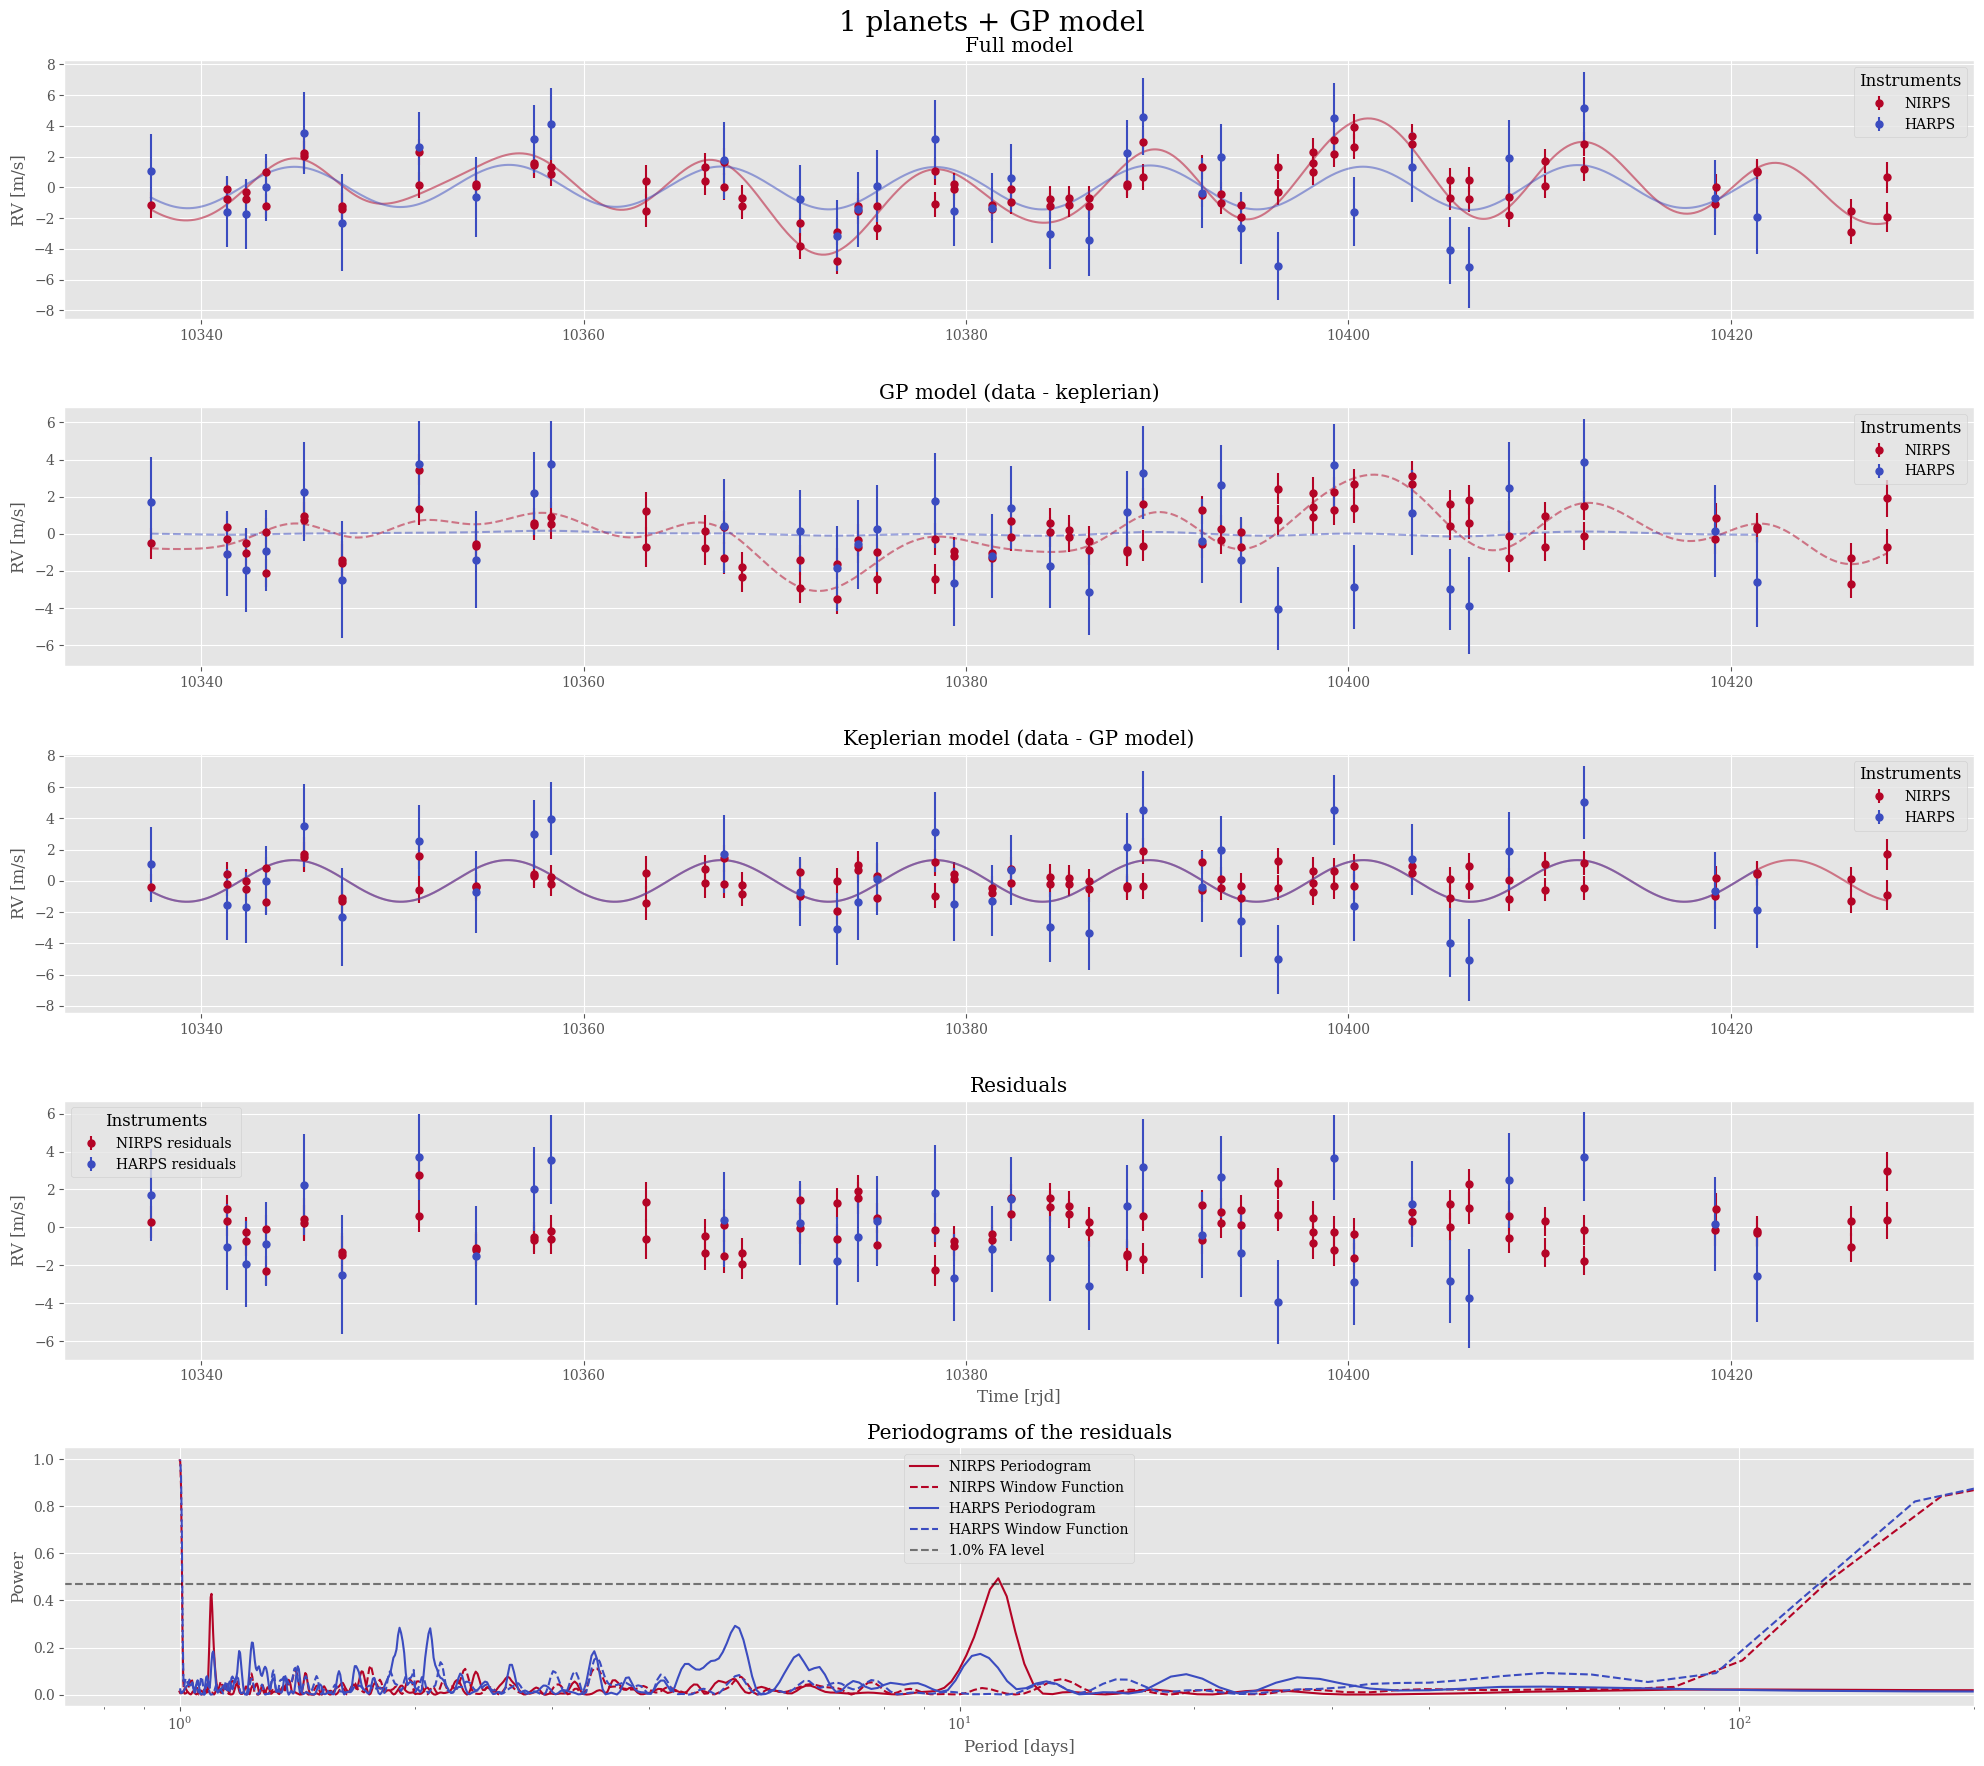

Done.


In [ ]:
print('Plotting the best-fit model and residuals')

# Plot the planets + GP model and the samples
fig, axes = plt.subplots(5, 1, figsize=(20, 18), sharex=False)
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))
rjd_off = 2450000
for idx, instrument in enumerate(data.instruments):
    # Plot data with error bars
    axes[0].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - med_params[3*num_planets+idx], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    axes[1].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['planet'] - med_params[3*num_planets+idx], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    axes[2].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['GP'], yerr=noise_terms[instrument], fmt="o", ms=5, label=f'{instrument}', color=colors[idx])
    
    # Plot median likelihood
    axes[2].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['planet'], color=colors[idx], linewidth=1.5, alpha=0.5)  # Keplerian
    axes[1].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['GP'] - med_params[3*num_planets+idx], color=colors[idx], linestyle='--', linewidth=1.5, alpha=0.5)  # GP
    axes[0].plot(data.t_mod[instrument] - rjd_off, model.predict(data.t_mod, return_components=True)[instrument]['planet'] + model.predict(data.t_mod, return_components=True)[instrument]['GP'] - med_params[3*num_planets+idx], color=colors[idx], linewidth=1.5, alpha=0.5)  # Full model
    
    # Plot residuals
    axes[3].errorbar(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv)[instrument], yerr=noise_terms[instrument], fmt='o', color=colors[idx], label=f'{instrument} residuals')
    
    # Plot the periodogram of the residuals
    ls = LombScargle(data.t_rv[instrument] - rjd_off, data.y_rv[instrument] - model.predict(data.t_rv)[instrument], dy=noise_terms[instrument])
    target_fap = 0.01
    fap = ls.false_alarm_level(target_fap)
    freq, power = ls.autopower(maximum_frequency=1.0)
    period = 1 / freq

    ls_window = LombScargle(data.t_rv[instrument] - rjd_off, np.ones_like(data.y_rv[instrument]), dy=noise_terms[instrument], fit_mean=False, center_data=False)
    power_window = ls_window.power(freq)

    axes[4].plot(period, power, color=colors[idx], label=f'{instrument} Periodogram')
    axes[4].plot(period, power_window, color=colors[idx], linestyle='--', label=f'{instrument} Window Function')

axes[4].axhline(fap, linestyle="--", color="black", label=f"{target_fap * 100}% FA level", alpha=0.5)

axes[0].set_title('Full model')
axes[1].set_title('GP model (data - keplerian)')
axes[2].set_title('Keplerian model (data - GP model)')
axes[3].set_title('Residuals')
axes[4].set_title('Periodograms of the residuals')
axes[3].set_xlabel('Time [rjd]')
axes[0].set_ylabel('RV [m/s]')
axes[1].set_ylabel('RV [m/s]')
axes[2].set_ylabel('RV [m/s]')
axes[3].set_ylabel('RV [m/s]')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[2].legend(title='Instruments')
axes[3].legend(title='Instruments')
axes[4].set_xlabel('Period [days]')
axes[4].set_ylabel('Power')
axes[4].legend()
axes[4].set_xscale('log')
axes[4].set_xlim(0, 200)
plt.suptitle(f'{num_planets} planets + GP model', fontsize=20)
plt.savefig(f'stars/{star}/joint_fit/planets+GP_best_fit.png')
plt.show()

print('Done.')

Plotting the random samples 

Plotting model samples
Done.


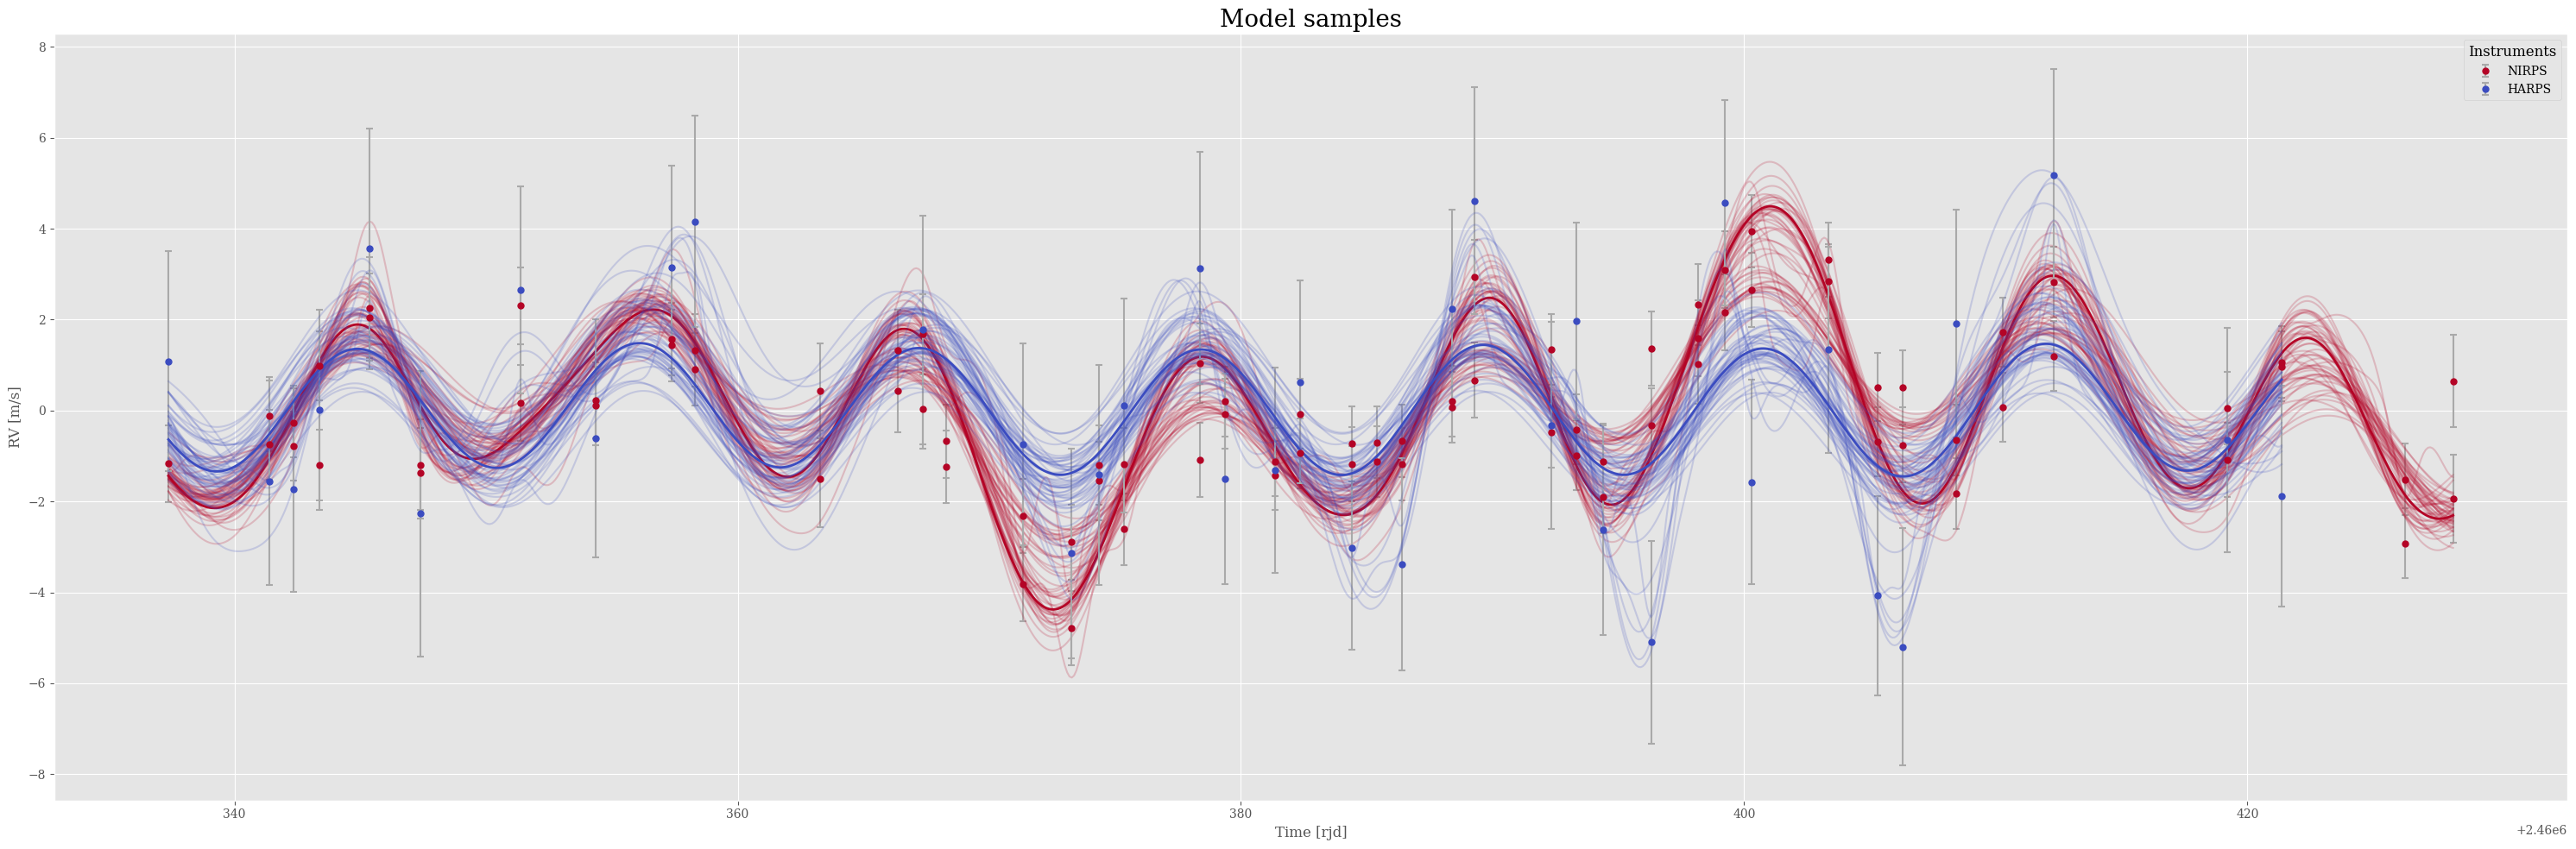

In [ ]:
print('Plotting model samples')

fig, ax = plt.subplots(1, 1, figsize=(30, 10))

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=noise_terms[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model_post_samples[instrument].T, alpha = 0.2, color = colors[idx])
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod)[instrument], color=colors[idx], lw=2)
    
ax.set_xlabel('Time [rjd]')
ax.set_ylabel('RV [m/s]')
ax.legend(title='Instruments')
ax.set_title('Model samples', fontsize = 20)

plt.savefig(f'stars/{star}/joint_fit/planet_model_samples.png')
print('Done.')

Plotting phase-folded RV curves of our planets...


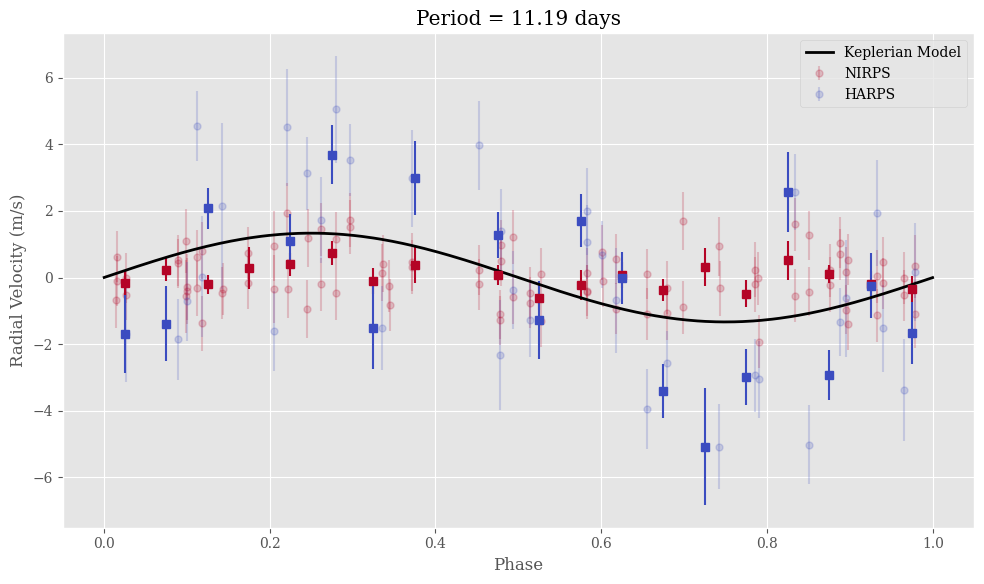

Done.


<Figure size 640x480 with 0 Axes>

In [ ]:
print('Plotting phase-folded RV curves of our planets...')

def foldAt(time, period, t0):
    return ((time - t0 + 0.5 * period) % period) / period

def bin_data(phases, RVs, RV_errs, num_bins=20):
    bins = np.linspace(0, 1, num_bins + 1)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    binned_RVs = np.zeros(num_bins)
    binned_errs = np.zeros(num_bins)
    
    for i in range(num_bins):
        in_bin = (phases >= bins[i]) & (phases < bins[i+1])
        if np.any(in_bin):
            weights = 1 / RV_errs[in_bin]**2
            binned_RVs[i] = np.sum(RVs[in_bin] * weights) / np.sum(weights)
            binned_errs[i] = np.sqrt(1 / np.sum(weights))
        else:
            binned_RVs[i] = np.nan
            binned_errs[i] = np.nan
    
    return bin_centers, binned_RVs, binned_errs

def phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, period, t0, instrument_names):
    colors = plt.cm.coolwarm(np.linspace(1, 0, len(data_times)))
    
    # Plotting the data
    plt.figure(figsize=(10, 6))
    
    for i, instrument in enumerate(instrument_names):
        # Fold the data and model times to get the phases
        phases_data = foldAt(data_times[instrument], period, t0)
        phases_model = foldAt(model_times[instrument], period, t0)

        # Sort the phases for plotting
        sort_indices_data = np.argsort(phases_data)
        sort_indices_model = np.argsort(phases_model)

        phases_data_sorted = phases_data[sort_indices_data]
        RV_sorted = RVs[instrument][sort_indices_data]
        
        phases_model_sorted = phases_model[sort_indices_model]
        keplerian_model_RVs_sorted = keplerian_model_RVs[instrument][sort_indices_model]

        # Plot the observed data
        plt.errorbar(phases_data_sorted, RV_sorted, yerr=RV_errs[instrument], fmt='o', color=colors[i], label=f'{instrument}', zorder=1, alpha = 0.2)
        
        # Bin the data and plot the binned points
        bin_centers, binned_RVs, binned_errs = bin_data(phases_data_sorted, RV_sorted, RV_errs[instrument][sort_indices_data])
        plt.errorbar(bin_centers, binned_RVs, yerr=binned_errs, fmt='s', color=colors[i], zorder=2, markersize = 6)
    
    # Plot the model
    plt.plot(phases_model_sorted, keplerian_model_RVs_sorted, color='black', label='Keplerian Model', lw=2)

    # Add labels and title
    plt.xlabel('Phase')
    plt.ylabel('Radial Velocity (m/s)')
    plt.title(f'Period = {period:.2f} days')
    plt.legend()
    plt.grid(True)
    
    # Show the plot
    plt.show()

# Loop through each planet and plot the data
for idx_planet in range(model.num_planets):
    planet_params = radvel.Parameters(1, basis='per tc secosw sesinw k')
    planet_params['per1'].value = med_params[3*idx_planet]
    planet_params['tc1'].value  = med_params[3*idx_planet+1]
    planet_params['k1'].value  = med_params[3*idx_planet+2]
    planet_params['secosw1'].value  = 0.0
    planet_params['sesinw1'].value  = 0.0

    # Create a Keplerian orbit model
    radvel_model = radvel.RVModel(planet_params)

    data_times = {instrument: data.t_rv[instrument] for instrument in data.instruments}
    model_times = {instrument: data.t_mod[instrument] for instrument in data.instruments}
    RVs = {instrument: data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['GP'] for instrument in data.instruments}
    RV_errs = {instrument: data.yerr_rv[instrument] for instrument in data.instruments}
    keplerian_model_RVs = {instrument: radvel_model(data.t_mod[instrument]) for instrument in data.instruments}
    
    phase_folded_plot(data_times, model_times, RVs, RV_errs, keplerian_model_RVs, med_params[3*idx_planet], med_params[3*idx_planet+1], data.instruments)
    
    plt.savefig(f'stars/{star}/joint_fit/phase_folded_planet_{idx_planet+1}.png')

print('Done.')

In [ ]:
print('All done! Hope you will be happy with your results')

All done! Hope you will be happy with your results
